In [1]:
import pickle
import numpy as np
import numpy.matlib as mt
from matplotlib import pyplot as plt
from scipy import signal,stats
from ephysvibe.structures.neuron_data import NeuronData
from ephysvibe.trials import align_trials
from ephysvibe.task import task_constants
import os 
import glob


from sklearn import metrics

In [2]:
with open('C:/Users/ibos.g/Documents/Data/INT-Marseille/OpenEphys/Riesling/ROCanalyses/LIPsampleROC', 'rb') as handle:
    lip = pickle.load(handle)

with open('C:/Users/ibos.g/Documents/Data/INT-Marseille/OpenEphys/Riesling/ROCanalyses/PFCsampleROC', 'rb') as handle:
    pfc = pickle.load(handle)    

with open('C:/Users/ibos.g/Documents/Data/INT-Marseille/OpenEphys/Riesling/ROCanalyses/V4sampleROC', 'rb') as handle:
    v4 = pickle.load(handle)        

In [3]:
def definelatencies(p_values, win, threshold):

   lat=[]

   for i in np.arange(p_values.shape[0]):
      
      tmp=[]
      
      sig=np.zeros(p_values.shape[1])
      sig[np.where(p_values[i,:]<0.01)]=1
      

      for i_step in np.arange(sig.shape[0]):
         if sig[i_step]==1 and np.sum(sig[i_step:i_step+win])>=threshold:
            tmp.append(i_step)  

      if not tmp:
         lat.append(np.nan)  
      else:
         lat.append(tmp[0])  
      
   lat=np.array(lat)

   return lat


In [67]:
def moving_average(data:np.ndarray,win:int, step:int=1)-> np.ndarray:
    d_shape=data.shape
    d_avg = np.zeros((d_shape[0],int(np.floor(d_shape[1]/step))))
    count = 0
    for i_step in np.arange(0,d_shape[1]-step,step):
        d_avg[:,count] = np.mean(data[:,i_step:i_step+win],axis=1)
        count +=1
    return d_avg

In [5]:
def sortrocvaluesbylatencies(values,lat):
    
    sig_cells       =   np.where(lat>=0)[0]
    nonsig_cells    =   np.where(np.isnan(lat))[0]

    pos_sig_cells=sig_cells[np.mean(values[sig_cells,:], axis=1)>=0]
    neg_sig_cells=sig_cells[np.mean(values[sig_cells,:], axis=1)<0]

    sortpos_sig=np.argsort(lat[pos_sig_cells])
    sortneg_sig=np.argsort(lat[neg_sig_cells])
    sorted_index=np.concatenate([neg_sig_cells[sortneg_sig], nonsig_cells, pos_sig_cells[sortpos_sig[::-1]]])
    return sorted_index
               

In [66]:
def scale_p(x, out_range=(-1, 1)):
    if np.sum(x>1) >0:
        return
    domain = 0, 1
    y = (x - (domain[1] + domain[0]) / 2) / (domain[1] - domain[0])
    return y * (out_range[1] - out_range[0]) + (out_range[1] + out_range[0]) / 2

In [71]:
directory_b1    =   "W:/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/session_struct/"
bhv_directory   =   os.path.normpath(str(directory_b1) +  "/bhv/")

area="pfc"
neurons_pfc_directory =   os.path.normpath(str(directory_b1) + area + "/neurons/*.h5")
neurons_pfc_files     =   glob.glob(neurons_pfc_directory, recursive=True)

# area="v4"
# neurons_v4_directory =   os.path.normpath(str(directory_b1) + area + "/neurons/*.h5")
# neurons_v4_files     =   glob.glob(neurons_v4_directory, recursive=True)

# area="lip"

# neurons_lip_directory =   os.path.normpath(str(directory_b1) + area + "/neurons/*.h5")
# neurons_lip_files     =   glob.glob(neurons_lip_directory, recursive=True)

In [399]:
neurons_lip_files

['W:\\invibe\\USERS\\IBOS\\data\\Riesling\\TSCM\\OpenEphys\\new_structure\\session_struct\\lip\\neurons\\2022-11-22_10-59-03_Riesling_lip_e1_r1_good1_neu.h5',
 'W:\\invibe\\USERS\\IBOS\\data\\Riesling\\TSCM\\OpenEphys\\new_structure\\session_struct\\lip\\neurons\\2022-11-22_10-59-03_Riesling_lip_e1_r1_good2_neu.h5',
 'W:\\invibe\\USERS\\IBOS\\data\\Riesling\\TSCM\\OpenEphys\\new_structure\\session_struct\\lip\\neurons\\2022-11-22_10-59-03_Riesling_lip_e1_r1_mua1_neu.h5',
 'W:\\invibe\\USERS\\IBOS\\data\\Riesling\\TSCM\\OpenEphys\\new_structure\\session_struct\\lip\\neurons\\2022-11-22_10-59-03_Riesling_lip_e1_r1_mua2_neu.h5',
 'W:\\invibe\\USERS\\IBOS\\data\\Riesling\\TSCM\\OpenEphys\\new_structure\\session_struct\\lip\\neurons\\2022-11-22_10-59-03_Riesling_lip_e1_r1_mua3_neu.h5',
 'W:\\invibe\\USERS\\IBOS\\data\\Riesling\\TSCM\\OpenEphys\\new_structure\\session_struct\\lip\\neurons\\2022-11-28_10-23-27_Riesling_lip_e1_r1_mua3_neu.h5',
 'W:\\invibe\\USERS\\IBOS\\data\\Riesling\\TSCM\\O

In [68]:
def compute_roc_auc(group1,group2):
    
    seed = 2023
    rng = np.random.default_rng(seed=seed)
    roc_score = []
    p = []
    for n_win in np.arange(group1.shape[1]):
        g1 = group1[:,n_win]
        g2 = group2[:,n_win]

        # Wilcoxon rank-sum 
        p.append(stats.ranksums(g1, g2)[1])#stats.ttest_ind

        thresholds = np.unique(np.concatenate([g1,g2]))

        y_g1, y_g2 = np.ones(len(g1)),np.zeros(len(g2))
        score=0.5
        fpr,tpr=[],[]
        for threshold in thresholds:
            g1_y_pred,g2_y_pred = np.zeros(len(g1)),np.zeros(len(g2))
            g1_mask,g2_mask = g1>=threshold,g2>=threshold
            g1_y_pred[g1_mask],g2_y_pred[g2_mask] = 1,1
            tp = sum(np.logical_and(y_g1==1,g1_y_pred==1))
            fn = sum(np.logical_and(y_g1==1,g1_y_pred==0))
            tpr.append(tp/ (tp+fn) )
            fp = sum(np.logical_and(y_g2==0,g2_y_pred==1))
            tn = sum(np.logical_and(y_g2==0,g2_y_pred==0))
            fpr.append(fp/ (fp+tn) )
        if len(fpr) > 1:
            fpr,tpr=np.array(fpr),np.array(tpr)
                      
            score = metrics.auc(fpr[fpr.argsort()],tpr[fpr.argsort()])
        roc_score.append(score)
        
    roc_score = np.array(roc_score)
    roc_score = scale_p(np.round(roc_score,2),out_range=[-1,1])
    return roc_score, p


In [104]:
data=NeuronData.from_python_hdf5(neurons_pfc_files[88])

In [105]:


code=1
select_block=1
time_before_sample  =   400
time_before_t1      =   450

timetotal_sample=   time_before_sample+450*3
timetotal_t1    =   time_before_t1+450*2
win=100
step=1
neu_data=data
sp_sample_in_on,mask_sample_in = align_trials.align_on(
            sp_samples=neu_data.sp_samples,
            code_samples=neu_data.code_samples,
            code_numbers=neu_data.code_numbers,
            trial_error=neu_data.trial_error,
            block=neu_data.block,
            pos_code=neu_data.pos_code,
            select_block= select_block,
            select_pos= code,
            event ="sample_on",
            time_before = time_before_sample,
            error_type= 0,
        )

sp_sample_out_on,mask_sample_out = align_trials.align_on(
            sp_samples=neu_data.sp_samples,
            code_samples=neu_data.code_samples,
            code_numbers=neu_data.code_numbers,
            trial_error=neu_data.trial_error,
            block=neu_data.block,
            pos_code=neu_data.pos_code,
            select_block= select_block,
            select_pos= -1,
            event ="sample_on",
            time_before = time_before_sample,
            error_type= 0,
        )

o1trials    =   np.where(np.floor(neu_data.sample_id[mask_sample_in]/10)==1)
o5trials    =   np.where(np.floor(neu_data.sample_id[mask_sample_in]/10)==5)

c1trials    =   np.where(neu_data.sample_id[mask_sample_in]%10==1)
c5trials    =   np.where(neu_data.sample_id[mask_sample_in]%10==5)

ntrials     =   np.where(neu_data.sample_id[mask_sample_in]==0)
nntrials    =   np.where(neu_data.sample_id[mask_sample_in]!=0)



In [117]:
sp_sample_in_on[:, :timetotal_sample]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [121]:


sin     =   moving_average(data=sp_sample_in_on[:, :timetotal_sample],win=win, step=step)[:,:-win]
sout    =   moving_average(data=sp_sample_out_on[:, :timetotal_sample],win=win, step=step)[:,:-win]


R,p=compute_roc_auc(sin, sout )


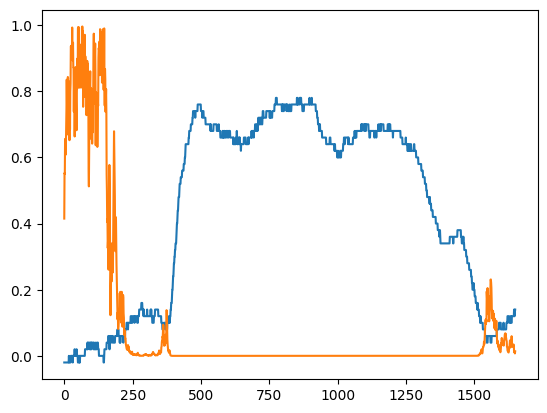

In [122]:


plt.plot(R)
plt.plot(p)

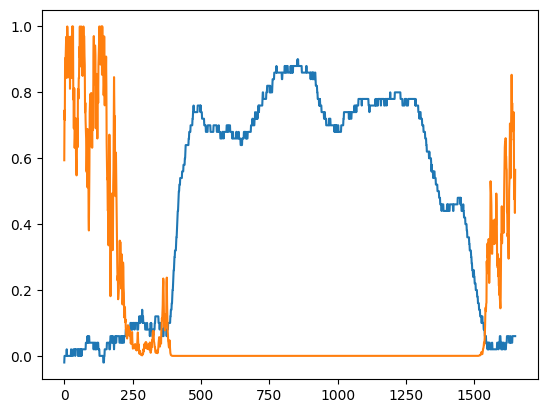

In [120]:
plt.plot(R)
plt.plot(p)

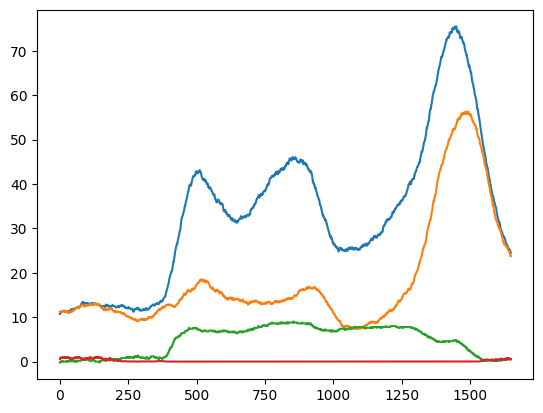

In [119]:
plt.plot(np.mean(sin*1000, axis=0))
plt.plot(np.mean(sout*1000, axis=0))
plt.plot(R*10)
plt.plot(p)


In [96]:
too_early=np.where(lat_pfc_position<350)
too_early

(array([  10,   88,  447,  485,  706,  941,  942,  954, 1017, 1144, 1162,
        1167], dtype=int64),)

In [56]:
lat_lip_color[to_early]

array([86.])

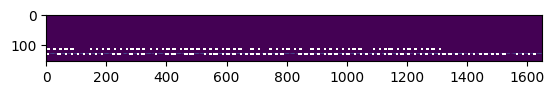

In [15]:
plt.imshow(lip_neutral_sample_value[np.sum(lip_position_sample_value, axis=1)>0])

In [45]:
np.where(lat_lip_color>0)[0].shape[0]/128

0.2109375

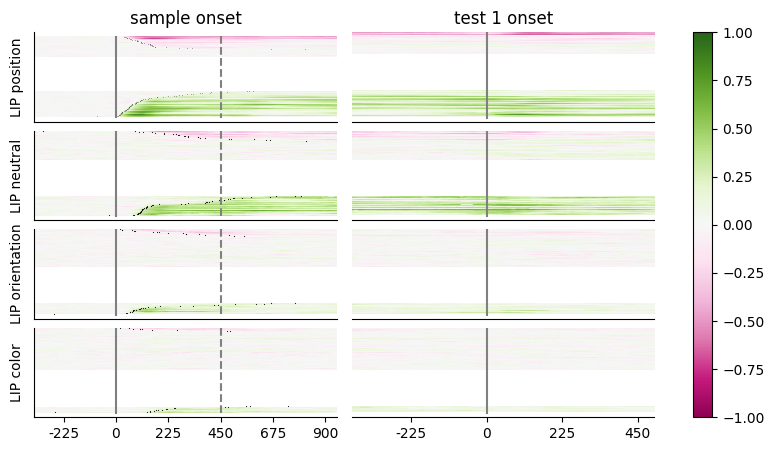

In [5]:
lip_neutral_sample_value    =   lip[0][1]
lip_neutral_test_value      =   lip[2][1]

lip_orient_sample_value     =   lip[0][3]
lip_orient_test_value       =   lip[2][3]

lip_color_sample_value      =   lip[0][5]
lip_color_test_value        =   lip[2][5]

lip_position_sample_value   =   lip[0][7]
lip_position_test_value     =   lip[2][7]

lip_neutral_sample_value[np.sum(lip_position_sample_value, axis=1)>0]
lat_lip_neutral     =   lip[4][1]
lat_lip_orient      =   lip[4][3]
lat_lip_color       =   lip[4][5]
lat_lip_position    =   lip[4][7]

lat_lip_position[lat_lip_position>1200]=np.nan
lat_lip_neutral[lat_lip_neutral>1200]=np.nan
lat_lip_orient[lat_lip_orient>1200]=np.nan
lat_lip_color[lat_lip_color>1200]=np.nan

sort_sneutral    =   sortrocvaluesbylatencies(lip_neutral_sample_value[:,450:900],lat_lip_neutral)
sort_sorient     =   sortrocvaluesbylatencies(lip_orient_sample_value[:,450:900],lat_lip_orient)
sort_scolor      =   sortrocvaluesbylatencies(lip_color_sample_value[:,450:900],lat_lip_color)
sort_sposition   =   sortrocvaluesbylatencies(lip_position_sample_value[:,450:900],lat_lip_position)

sort_tneutral    =   np.argsort(np.mean(lip_neutral_test_value[:,450:900], axis=1))
sort_torient     =   np.argsort(np.mean(lip_orient_test_value[:,450:900], axis=1))
sort_tcolor      =   np.argsort(np.mean(lip_color_test_value[:,450:900], axis=1))
sort_tposition   =   np.argsort(np.mean(lip_position_test_value[:,450:900], axis=1))

sort_neutral    =   sort_sneutral
sort_orient     =   sort_sorient
sort_color      =   sort_scolor
sort_position   =   sort_sposition


# fig     =   plt.figure(figsize=(10,10))
fig, ax      =   plt.subplots(4,2,figsize=(10,5))

# im0       =   sns.heatmap(lip_position_sample_value[sort_position,:1300], vmin=-1, vmax=1, cmap='PiYG', ax=ax[0,0])#
im0       =   ax[0,0].imshow(lip_position_sample_value[sort_position,:1300], vmin=-1, vmax=1, cmap='PiYG', aspect='auto', interpolation='bilinear')
im1       =   ax[0,1].imshow(lip_position_test_value[sort_position,:900], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')

im2       =   ax[1,0].imshow(lip_neutral_sample_value[sort_neutral,:1300], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')
im3       =   ax[1,1].imshow(lip_neutral_test_value[sort_neutral,:900], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')

im4       =   ax[2,0].imshow(lip_orient_sample_value[sort_orient,:1300], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')
im5       =   ax[2,1].imshow(lip_orient_test_value[sort_orient,:900], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')

im6       =   ax[3,0].imshow(lip_color_sample_value[sort_color,:1300], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')
im7       =   ax[3,1].imshow(lip_color_test_value[sort_color,:900], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')

ax[0,0].scatter(lat_lip_position[sort_position], np.arange(lat_lip_position.shape[0])-0.5, marker ='o', color=[0, 0, 0], linewidths=0.1,s=0.1)
ax[1,0].scatter(lat_lip_neutral[sort_neutral], np.arange(lat_lip_neutral.shape[0])-0.5, marker ='o', color=[0, 0, 0], linewidths=0.1,s=0.5)
ax[2,0].scatter(lat_lip_orient[sort_orient], np.arange(lat_lip_orient.shape[0])-0.5, marker ='o', color=[0, 0, 0], linewidths=0.1,s=.5)
ax[3,0].scatter(lat_lip_color[sort_color], np.arange(lat_lip_color.shape[0])-0.5, marker ='o', color=[0, 0, 0], linewidths=0.1,s=.5)

# ax[0,0].plot([lat_lip_position[sort_position], lat_lip_position[sort_position]], [np.arange(lat_lip_position.shape[0])-.5, np.arange(lat_lip_position.shape[0])+0.5], color=[0, 0, 0], linewidth=1)
# ax[1,0].plot([lat_lip_neutral[sort_neutral], lat_lip_neutral[sort_neutral]], [np.arange(lat_lip_neutral.shape[0])-.5, np.arange(lat_lip_neutral.shape[0])+.5], color=[0, 0, 0], linewidth=1)
# ax[2,0].plot([lat_lip_orient[sort_orient], lat_lip_orient[sort_orient]], [np.arange(lat_lip_orient.shape[0])-.5, np.arange(lat_lip_orient.shape[0])+.5], color=[0, 0, 0], linewidth=1)
# ax[3,0].plot([lat_lip_color[sort_color], lat_lip_color[sort_color]], [np.arange(lat_lip_color.shape[0])-.5, np.arange(lat_lip_color.shape[0])+.5], color=[0, 0, 0], linewidth=1)

ax[0,0].plot([350,350],[0, sort_neutral.shape[0]],color=(0.5, .5, .5))
ax[1,0].plot([350,350],[0, sort_neutral.shape[0]],color=(0.5, .5, .5))
ax[2,0].plot([350,350],[0, sort_neutral.shape[0]],color=(0.5, .5, .5))
ax[3,0].plot([350,350],[0, sort_neutral.shape[0]],color=(0.5, .5, .5))

ax[0,0].plot([350+450,350+450],[-1, sort_neutral.shape[0]+2],color=(0.5, .5, .5),linestyle='dashed')
ax[1,0].plot([350+450,350+450],[0, sort_neutral.shape[0]],color=(0.5, .5, .5),linestyle='dashed')
ax[2,0].plot([350+450,350+450],[0, sort_neutral.shape[0]],color=(0.5, .5, .5), linestyle='dashed')
ax[3,0].plot([350+450,350+450],[0, sort_neutral.shape[0]],color=(0.5, .5, .5), linestyle='dashed')

ax[0,1].plot([400,400],[2, sort_neutral.shape[0]+2],color=(0.5, .5, .5))
ax[1,1].plot([400,400],[0, sort_neutral.shape[0]+1],color=(0.5, .5, .5))
ax[2,1].plot([400,400],[0, sort_neutral.shape[0]+1],color=(0.5, .5, .5))
ax[3,1].plot([400,400],[0, sort_neutral.shape[0]+1],color=(0.5, .5, .5))

ax[0,0].set_xticks([])
ax[0,0].set_yticks([])
ax[0,0].set_title('sample onset')
ax[0,0].set_ylabel('LIP position')
ax[0,0].spines['top'].set_visible(False)
ax[0,0].spines['right'].set_visible(False)

ax[0,1].set_xticks([])
ax[0,1].set_yticks([])
ax[0,1].set_title('test 1 onset')
ax[0,1].spines['top'].set_visible(False)
ax[0,1].spines['right'].set_visible(False)
ax[0,1].spines['left'].set_visible(False)

ax[1,0].set_xticks([])
ax[1,0].set_yticks([])

ax[1,0].set_ylabel('LIP neutral')
ax[1,0].spines['top'].set_visible(False)
ax[1,0].spines['right'].set_visible(False)

ax[1,1].set_xticks([])
ax[1,1].set_yticks([])
ax[1,1].spines['top'].set_visible(False)
ax[1,1].spines['right'].set_visible(False)
ax[1,1].spines['left'].set_visible(False)

ax[2,0].set_xticks([])
ax[2,0].set_yticks([])
ax[2,0].set_ylabel('LIP orientation')
ax[2,0].spines['top'].set_visible(False)
ax[2,0].spines['right'].set_visible(False)

ax[2,1].set_xticks([])
ax[2,1].set_yticks([])
ax[2,1].spines['top'].set_visible(False)
ax[2,1].spines['right'].set_visible(False)
ax[2,1].spines['left'].set_visible(False)

ax[3,0].set_xticks([350+225*(-1), 350+225*(0), 350+225*(1), 350+225*(2), 350+225*(3), 350+225*(4)])
ax[3,0].set_xticklabels(['-225', '0', '225', '450', '675', '900'])
ax[3,0].set_yticks([])
ax[3,0].set_ylabel('LIP color')
ax[3,0].spines['top'].set_visible(False)
ax[3,0].spines['right'].set_visible(False)

ax[3,1].set_xticks([400+225*(-1), 400+225*(0), 400+225*(1), 400+225*(2)])
ax[3,1].set_xticklabels(['-225', '0', '225', '450'])
ax[3,1].set_yticks([])
ax[3,1].spines['top'].set_visible(False)
ax[3,1].spines['right'].set_visible(False)
ax[3,1].spines['left'].set_visible(False)

fig.subplots_adjust(wspace=0.05, hspace=0.1)
fig.colorbar(im2, ax=ax)

# plt.savefig('C:/Users/ibos.g/Documents/Data/INT-Marseille/OpenEphys/Riesling/figures/ROC_lip.pdf')  

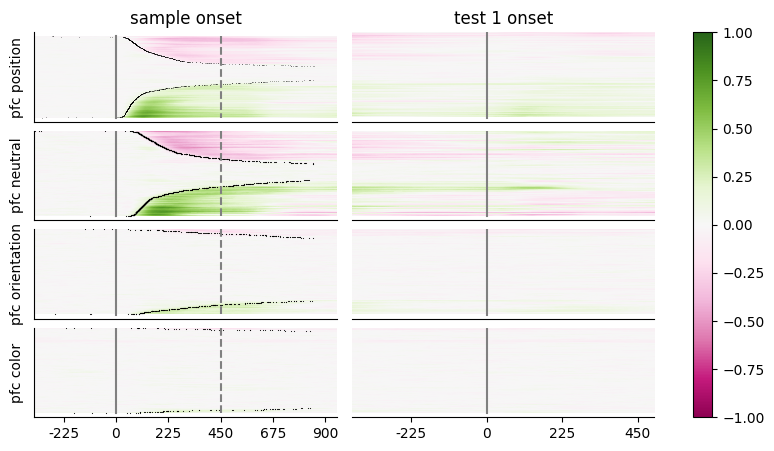

In [6]:
pfc_neutral_sample_value    =   pfc[0][1]
pfc_neutral_test_value      =   pfc[2][1]

pfc_orient_sample_value     =   pfc[0][3]
pfc_orient_test_value       =   pfc[2][3]

pfc_color_sample_value      =   pfc[0][5]
pfc_color_test_value        =   pfc[2][5]

pfc_position_sample_value   =   pfc[0][7]
pfc_position_test_value     =   pfc[2][7]

lat_pfc_neutral     =   pfc[4][1]
lat_pfc_orient      =   pfc[4][3]
lat_pfc_color       =   pfc[4][5]
lat_pfc_position    =   pfc[4][7]

lat_pfc_position[lat_pfc_position>1200]=np.nan
lat_pfc_neutral[lat_pfc_neutral>1200]=np.nan
lat_pfc_orient[lat_pfc_orient>1200]=np.nan
lat_pfc_color[lat_pfc_color>1200]=np.nan

sort_sneutral    =   sortrocvaluesbylatencies(pfc_neutral_sample_value[:,450:900],lat_pfc_neutral)
sort_sorient     =   sortrocvaluesbylatencies(pfc_orient_sample_value[:,450:900],lat_pfc_orient)
sort_scolor      =   sortrocvaluesbylatencies(pfc_color_sample_value[:,450:900],lat_pfc_color)
sort_sposition   =   sortrocvaluesbylatencies(pfc_position_sample_value[:,450:900],lat_pfc_position)

sort_tneutral    =   np.argsort(np.mean(pfc_neutral_test_value[:,450:900], axis=1))
sort_torient     =   np.argsort(np.mean(pfc_orient_test_value[:,450:900], axis=1))
sort_tcolor      =   np.argsort(np.mean(pfc_color_test_value[:,450:900], axis=1))
sort_tposition   =   np.argsort(np.mean(pfc_position_test_value[:,450:900], axis=1))

sort_neutral    =   sort_sneutral
sort_orient     =   sort_sorient
sort_color      =   sort_scolor
sort_position   =   sort_sposition


# fig     =   plt.figure(figsize=(10,10))
fig, ax      =   plt.subplots(4,2,figsize=(10,5))

# im0       =   sns.heatmap(pfc_position_sample_value[sort_position,:1300], vmin=-1, vmax=1, cmap='PiYG', ax=ax[0,0])#
im0       =   ax[0,0].imshow(pfc_position_sample_value[sort_position,:1300], vmin=-1, vmax=1, cmap='PiYG', aspect='auto', interpolation='bilinear')
im1       =   ax[0,1].imshow(pfc_position_test_value[sort_position,:900], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')

im2       =   ax[1,0].imshow(pfc_neutral_sample_value[sort_neutral,:1300], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')
im3       =   ax[1,1].imshow(pfc_neutral_test_value[sort_neutral,:900], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')

im4       =   ax[2,0].imshow(pfc_orient_sample_value[sort_orient,:1300], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')
im5       =   ax[2,1].imshow(pfc_orient_test_value[sort_orient,:900], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')

im6       =   ax[3,0].imshow(pfc_color_sample_value[sort_color,:1300], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')
im7       =   ax[3,1].imshow(pfc_color_test_value[sort_color,:900], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')

ax[0,0].scatter(lat_pfc_position[sort_position], np.arange(lat_pfc_position.shape[0])-0.5, marker ='o', color=[0, 0, 0], linewidths=0.1,s=0.1)
ax[1,0].scatter(lat_pfc_neutral[sort_neutral], np.arange(lat_pfc_neutral.shape[0])-0.5, marker ='o', color=[0, 0, 0], linewidths=0.1,s=0.5)
ax[2,0].scatter(lat_pfc_orient[sort_orient], np.arange(lat_pfc_orient.shape[0])-0.5, marker ='o', color=[0, 0, 0], linewidths=0.1,s=.5)
ax[3,0].scatter(lat_pfc_color[sort_color], np.arange(lat_pfc_color.shape[0])-0.5, marker ='o', color=[0, 0, 0], linewidths=0.1,s=.5)

# ax[0,0].plot([lat_pfc_position[sort_position], lat_pfc_position[sort_position]], [np.arange(lat_pfc_position.shape[0])-.5, np.arange(lat_pfc_position.shape[0])+0.5], color=[0, 0, 0], linewidth=1)
# # ax[1,0].plot([lat_pfc_neutral[sort_neutral], lat_pfc_neutral[sort_neutral]], [np.arange(lat_pfc_neutral.shape[0])-.5, np.arange(lat_pfc_neutral.shape[0])+.5], color=[0, 0, 0], linewidth=1)
# ax[2,0].plot([lat_pfc_orient[sort_orient], lat_pfc_orient[sort_orient]], [np.arange(lat_pfc_orient.shape[0])-.5, np.arange(lat_pfc_orient.shape[0])+.5], color=[0, 0, 0], linewidth=1)
# ax[3,0].plot([lat_pfc_color[sort_color], lat_pfc_color[sort_color]], [np.arange(lat_pfc_color.shape[0])-.5, np.arange(lat_pfc_color.shape[0])+.5], color=[0, 0, 0], linewidth=1)

ax[0,0].plot([350,350],[0, sort_neutral.shape[0]],color=(0.5, .5, .5))
ax[1,0].plot([350,350],[0, sort_neutral.shape[0]],color=(0.5, .5, .5))
ax[2,0].plot([350,350],[0, sort_neutral.shape[0]],color=(0.5, .5, .5))
ax[3,0].plot([350,350],[0, sort_neutral.shape[0]],color=(0.5, .5, .5))

ax[0,0].plot([350+450,350+450],[-1, sort_neutral.shape[0]+2],color=(0.5, .5, .5),linestyle='dashed')
ax[1,0].plot([350+450,350+450],[0, sort_neutral.shape[0]],color=(0.5, .5, .5),linestyle='dashed')
ax[2,0].plot([350+450,350+450],[0, sort_neutral.shape[0]],color=(0.5, .5, .5), linestyle='dashed')
ax[3,0].plot([350+450,350+450],[0, sort_neutral.shape[0]],color=(0.5, .5, .5), linestyle='dashed')

ax[0,1].plot([400,400],[2, sort_neutral.shape[0]+2],color=(0.5, .5, .5))
ax[1,1].plot([400,400],[0, sort_neutral.shape[0]+1],color=(0.5, .5, .5))
ax[2,1].plot([400,400],[0, sort_neutral.shape[0]+1],color=(0.5, .5, .5))
ax[3,1].plot([400,400],[0, sort_neutral.shape[0]+1],color=(0.5, .5, .5))

ax[0,0].set_xticks([])
ax[0,0].set_yticks([])
ax[0,0].set_title('sample onset')
ax[0,0].set_ylabel('pfc position')
ax[0,0].spines['top'].set_visible(False)
ax[0,0].spines['right'].set_visible(False)

ax[0,1].set_xticks([])
ax[0,1].set_yticks([])
ax[0,1].set_title('test 1 onset')
ax[0,1].spines['top'].set_visible(False)
ax[0,1].spines['right'].set_visible(False)
ax[0,1].spines['left'].set_visible(False)

ax[1,0].set_xticks([])
ax[1,0].set_yticks([])

ax[1,0].set_ylabel('pfc neutral')
ax[1,0].spines['top'].set_visible(False)
ax[1,0].spines['right'].set_visible(False)

ax[1,1].set_xticks([])
ax[1,1].set_yticks([])
ax[1,1].spines['top'].set_visible(False)
ax[1,1].spines['right'].set_visible(False)
ax[1,1].spines['left'].set_visible(False)

ax[2,0].set_xticks([])
ax[2,0].set_yticks([])
ax[2,0].set_ylabel('pfc orientation')
ax[2,0].spines['top'].set_visible(False)
ax[2,0].spines['right'].set_visible(False)

ax[2,1].set_xticks([])
ax[2,1].set_yticks([])
ax[2,1].spines['top'].set_visible(False)
ax[2,1].spines['right'].set_visible(False)
ax[2,1].spines['left'].set_visible(False)

ax[3,0].set_xticks([350+225*(-1), 350+225*(0), 350+225*(1), 350+225*(2), 350+225*(3), 350+225*(4)])
ax[3,0].set_xticklabels(['-225', '0', '225', '450', '675', '900'])
ax[3,0].set_yticks([])
ax[3,0].set_ylabel('pfc color')
ax[3,0].spines['top'].set_visible(False)
ax[3,0].spines['right'].set_visible(False)

ax[3,1].set_xticks([400+225*(-1), 400+225*(0), 400+225*(1), 400+225*(2)])
ax[3,1].set_xticklabels(['-225', '0', '225', '450'])
ax[3,1].set_yticks([])
ax[3,1].spines['top'].set_visible(False)
ax[3,1].spines['right'].set_visible(False)
ax[3,1].spines['left'].set_visible(False)

fig.subplots_adjust(wspace=0.05, hspace=0.1)
fig.colorbar(im2, ax=ax)

plt.savefig('C:/Users/ibos.g/Documents/Data/INT-Marseille/OpenEphys/Riesling/figures/ROC_pfc.pdf')  

In [64]:
too_early=np.where(lat_pfc_position<350)
lat_pfc_position[too_early[0]]
pfc[6][10]

'2022-12-01_good_2'

In [65]:
too_early

(array([  10,   88,  447,  485,  706,  941,  942,  954, 1017, 1144, 1162,
        1167], dtype=int64),)

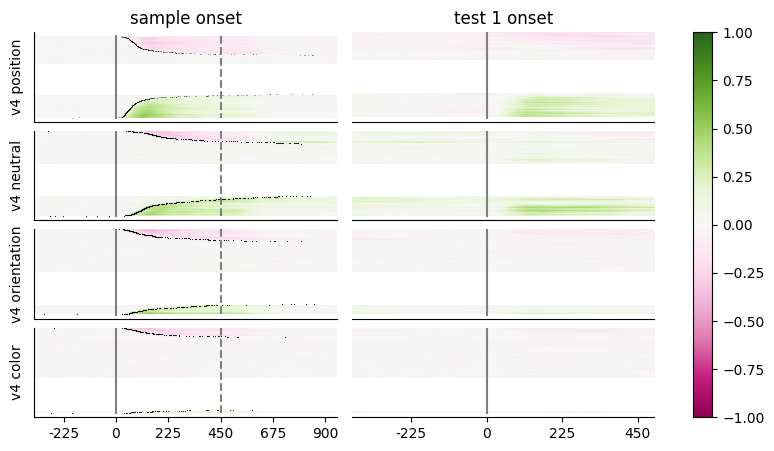

In [7]:
v4_neutral_sample_value    =   v4[0][1]
v4_neutral_test_value      =   v4[2][1]

v4_orient_sample_value     =   v4[0][3]
v4_orient_test_value       =   v4[2][3]

v4_color_sample_value      =   v4[0][5]
v4_color_test_value        =   v4[2][5]

v4_position_sample_value   =   v4[0][7]
v4_position_test_value     =   v4[2][7]

lat_v4_neutral     =   v4[4][1]
lat_v4_orient      =   v4[4][3]
lat_v4_color       =   v4[4][5]
lat_v4_position    =   v4[4][7]

lat_v4_position[lat_v4_position>1200]=np.nan
lat_v4_neutral[lat_v4_neutral>1200]=np.nan
lat_v4_orient[lat_v4_orient>1200]=np.nan
lat_v4_color[lat_v4_color>1200]=np.nan

sort_sneutral    =   sortrocvaluesbylatencies(v4_neutral_sample_value[:,450:900],lat_v4_neutral)
sort_sorient     =   sortrocvaluesbylatencies(v4_orient_sample_value[:,450:900],lat_v4_orient)
sort_scolor      =   sortrocvaluesbylatencies(v4_color_sample_value[:,450:900],lat_v4_color)
sort_sposition   =   sortrocvaluesbylatencies(v4_position_sample_value[:,450:900],lat_v4_position)

sort_tneutral    =   np.argsort(np.mean(v4_neutral_test_value[:,450:900], axis=1))
sort_torient     =   np.argsort(np.mean(v4_orient_test_value[:,450:900], axis=1))
sort_tcolor      =   np.argsort(np.mean(v4_color_test_value[:,450:900], axis=1))
sort_tposition   =   np.argsort(np.mean(v4_position_test_value[:,450:900], axis=1))

sort_neutral    =   sort_sneutral
sort_orient     =   sort_sorient
sort_color      =   sort_scolor
sort_position   =   sort_sposition


# fig     =   plt.figure(figsize=(10,10))
fig, ax      =   plt.subplots(4,2,figsize=(10,5))

# im0       =   sns.heatmap(v4_position_sample_value[sort_position,:1300], vmin=-1, vmax=1, cmap='PiYG', ax=ax[0,0])#
im0       =   ax[0,0].imshow(v4_position_sample_value[sort_position,:1300], vmin=-1, vmax=1, cmap='PiYG', aspect='auto', interpolation='bilinear')
im1       =   ax[0,1].imshow(v4_position_test_value[sort_position,:900], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')

im2       =   ax[1,0].imshow(v4_neutral_sample_value[sort_neutral,:1300], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')
im3       =   ax[1,1].imshow(v4_neutral_test_value[sort_neutral,:900], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')

im4       =   ax[2,0].imshow(v4_orient_sample_value[sort_orient,:1300], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')
im5       =   ax[2,1].imshow(v4_orient_test_value[sort_orient,:900], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')

im6       =   ax[3,0].imshow(v4_color_sample_value[sort_color,:1300], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')
im7       =   ax[3,1].imshow(v4_color_test_value[sort_color,:900], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')

ax[0,0].scatter(lat_v4_position[sort_position], np.arange(lat_v4_position.shape[0])-0.5, marker ='o', color=[0, 0, 0], linewidths=0.1,s=0.1)
ax[1,0].scatter(lat_v4_neutral[sort_neutral], np.arange(lat_v4_neutral.shape[0])-0.5, marker ='o', color=[0, 0, 0], linewidths=0.1,s=0.5)
ax[2,0].scatter(lat_v4_orient[sort_orient], np.arange(lat_v4_orient.shape[0])-0.5, marker ='o', color=[0, 0, 0], linewidths=0.1,s=.5)
ax[3,0].scatter(lat_v4_color[sort_color], np.arange(lat_v4_color.shape[0])-0.5, marker ='o', color=[0, 0, 0], linewidths=0.1,s=.5)

# ax[0,0].plot([lat_v4_position[sort_position], lat_v4_position[sort_position]], [np.arange(lat_v4_position.shape[0])-.5, np.arange(lat_v4_position.shape[0])+0.5], color=[0, 0, 0], linewidth=1)
# # ax[1,0].plot([lat_v4_neutral[sort_neutral], lat_v4_neutral[sort_neutral]], [np.arange(lat_v4_neutral.shape[0])-.5, np.arange(lat_v4_neutral.shape[0])+.5], color=[0, 0, 0], linewidth=1)
# ax[2,0].plot([lat_v4_orient[sort_orient], lat_v4_orient[sort_orient]], [np.arange(lat_v4_orient.shape[0])-.5, np.arange(lat_v4_orient.shape[0])+.5], color=[0, 0, 0], linewidth=1)
# ax[3,0].plot([lat_v4_color[sort_color], lat_v4_color[sort_color]], [np.arange(lat_v4_color.shape[0])-.5, np.arange(lat_v4_color.shape[0])+.5], color=[0, 0, 0], linewidth=1)

ax[0,0].plot([350,350],[0, sort_neutral.shape[0]],color=(0.5, .5, .5))
ax[1,0].plot([350,350],[0, sort_neutral.shape[0]],color=(0.5, .5, .5))
ax[2,0].plot([350,350],[0, sort_neutral.shape[0]],color=(0.5, .5, .5))
ax[3,0].plot([350,350],[0, sort_neutral.shape[0]],color=(0.5, .5, .5))

ax[0,0].plot([350+450,350+450],[-1, sort_neutral.shape[0]+2],color=(0.5, .5, .5),linestyle='dashed')
ax[1,0].plot([350+450,350+450],[0, sort_neutral.shape[0]],color=(0.5, .5, .5),linestyle='dashed')
ax[2,0].plot([350+450,350+450],[0, sort_neutral.shape[0]],color=(0.5, .5, .5), linestyle='dashed')
ax[3,0].plot([350+450,350+450],[0, sort_neutral.shape[0]],color=(0.5, .5, .5), linestyle='dashed')

ax[0,1].plot([400,400],[2, sort_neutral.shape[0]+2],color=(0.5, .5, .5))
ax[1,1].plot([400,400],[0, sort_neutral.shape[0]+1],color=(0.5, .5, .5))
ax[2,1].plot([400,400],[0, sort_neutral.shape[0]+1],color=(0.5, .5, .5))
ax[3,1].plot([400,400],[0, sort_neutral.shape[0]+1],color=(0.5, .5, .5))

ax[0,0].set_xticks([])
ax[0,0].set_yticks([])
ax[0,0].set_title('sample onset')
ax[0,0].set_ylabel('v4 position')
ax[0,0].spines['top'].set_visible(False)
ax[0,0].spines['right'].set_visible(False)

ax[0,1].set_xticks([])
ax[0,1].set_yticks([])
ax[0,1].set_title('test 1 onset')
ax[0,1].spines['top'].set_visible(False)
ax[0,1].spines['right'].set_visible(False)
ax[0,1].spines['left'].set_visible(False)

ax[1,0].set_xticks([])
ax[1,0].set_yticks([])

ax[1,0].set_ylabel('v4 neutral')
ax[1,0].spines['top'].set_visible(False)
ax[1,0].spines['right'].set_visible(False)

ax[1,1].set_xticks([])
ax[1,1].set_yticks([])
ax[1,1].spines['top'].set_visible(False)
ax[1,1].spines['right'].set_visible(False)
ax[1,1].spines['left'].set_visible(False)

ax[2,0].set_xticks([])
ax[2,0].set_yticks([])
ax[2,0].set_ylabel('v4 orientation')
ax[2,0].spines['top'].set_visible(False)
ax[2,0].spines['right'].set_visible(False)

ax[2,1].set_xticks([])
ax[2,1].set_yticks([])
ax[2,1].spines['top'].set_visible(False)
ax[2,1].spines['right'].set_visible(False)
ax[2,1].spines['left'].set_visible(False)

ax[3,0].set_xticks([350+225*(-1), 350+225*(0), 350+225*(1), 350+225*(2), 350+225*(3), 350+225*(4)])
ax[3,0].set_xticklabels(['-225', '0', '225', '450', '675', '900'])
ax[3,0].set_yticks([])
ax[3,0].set_ylabel('v4 color')
ax[3,0].spines['top'].set_visible(False)
ax[3,0].spines['right'].set_visible(False)

ax[3,1].set_xticks([400+225*(-1), 400+225*(0), 400+225*(1), 400+225*(2)])
ax[3,1].set_xticklabels(['-225', '0', '225', '450'])
ax[3,1].set_yticks([])
ax[3,1].spines['top'].set_visible(False)
ax[3,1].spines['right'].set_visible(False)
ax[3,1].spines['left'].set_visible(False)

fig.subplots_adjust(wspace=0.05, hspace=0.1)
fig.colorbar(im2, ax=ax)

# plt.savefig('C:/Users/ibos.g/Documents/Data/INT-Marseille/OpenEphys/Riesling/figures/ROC_v4.pdf')  

In [7]:
Num_lip_cells   =   lip[0][1].shape[0]
Num_pfc_cells   =   pfc[0][1].shape[0]
Num_v4_cells    =   v4[0][1].shape[0]

lat_rand_v4_position    =   np.empty((1000,Num_lip_cells,))*np.nan
lat_rand_pfc_position   =   np.empty((1000,Num_lip_cells,))*np.nan

lat_rand_v4_neutral     =   np.empty((1000,Num_lip_cells,))*np.nan
lat_rand_pfc_neutral    =   np.empty((1000,Num_lip_cells,))*np.nan

lat_rand_v4_orient      =   np.empty((1000,Num_lip_cells,))*np.nan
lat_rand_pfc_orient     =   np.empty((1000,Num_lip_cells,))*np.nan

lat_rand_v4_color       =   np.empty((1000,Num_lip_cells,))*np.nan
lat_rand_pfc_color      =   np.empty((1000,Num_lip_cells,))*np.nan

for j in range(1000):
    select_pfc_cells    =    np.random.choice(Num_pfc_cells, Num_lip_cells, replace=False)
    select_v4_cells     =    np.random.choice(Num_v4_cells, Num_lip_cells, replace=False)

    lat_rand_pfc_position[j,:]  =   lat_pfc_position[select_pfc_cells]
    lat_rand_v4_position[j,:]   =   lat_v4_position[select_v4_cells]

    lat_rand_pfc_neutral[j,:]  =   lat_pfc_neutral[select_pfc_cells]
    lat_rand_v4_neutral[j,:]   =   lat_v4_neutral[select_v4_cells]
    
    lat_rand_pfc_orient[j,:]  =   lat_pfc_orient[select_pfc_cells]
    lat_rand_v4_orient[j,:]   =   lat_v4_orient[select_v4_cells]
    
    lat_rand_pfc_color[j,:]  =   lat_pfc_color[select_pfc_cells]
    lat_rand_v4_color[j,:]   =   lat_v4_color[select_v4_cells]


    

In [14]:
lat_diff_lip_v4_position    =   np.reshape(mt.repmat(lat_rand_v4_position[0],lat_rand_v4_position[0].shape[0],1)-np.transpose(mt.repmat(lat_lip_position,lat_lip_position.shape[0],1)), [1, lat_lip_position.shape[0]*lat_lip_position.shape[0]])
lat_diff_lip_pfc_position   =   np.reshape(mt.repmat(lat_rand_pfc_position[0],lat_rand_pfc_position[0].shape[0],1)-np.transpose(mt.repmat(lat_lip_position,lat_lip_position.shape[0],1)), [1, lat_lip_position.shape[0]*lat_lip_position.shape[0]])
lat_diff_lip_v4_position    =   lat_diff_lip_v4_position[lat_diff_lip_v4_position>-3000]
lat_diff_lip_pfc_position   =   lat_diff_lip_pfc_position[lat_diff_lip_pfc_position>-3000]

lat_diff_lip_v4_neutral    =   np.reshape(mt.repmat(lat_rand_v4_neutral[0],lat_rand_v4_neutral[0].shape[0],1)-np.transpose(mt.repmat(lat_lip_neutral,lat_lip_neutral.shape[0],1)), [1, lat_lip_neutral.shape[0]*lat_lip_neutral.shape[0]])
lat_diff_lip_pfc_neutral   =   np.reshape(mt.repmat(lat_rand_pfc_neutral[0],lat_rand_pfc_neutral[0].shape[0],1)-np.transpose(mt.repmat(lat_lip_neutral,lat_lip_neutral.shape[0],1)), [1, lat_lip_neutral.shape[0]*lat_lip_neutral.shape[0]])
lat_diff_lip_v4_neutral    =   lat_diff_lip_v4_neutral[lat_diff_lip_v4_neutral>-3000]
lat_diff_lip_pfc_neutral   =   lat_diff_lip_pfc_neutral[lat_diff_lip_pfc_neutral>-3000]

lat_diff_lip_v4_orient    =   np.reshape(mt.repmat(lat_rand_v4_orient[0],lat_rand_v4_orient[0].shape[0],1)-np.transpose(mt.repmat(lat_lip_orient,lat_lip_orient.shape[0],1)), [1, lat_lip_orient.shape[0]*lat_lip_orient.shape[0]])
lat_diff_lip_pfc_orient   =   np.reshape(mt.repmat(lat_rand_pfc_orient[0],lat_rand_pfc_orient[0].shape[0],1)-np.transpose(mt.repmat(lat_lip_orient,lat_lip_orient.shape[0],1)), [1, lat_lip_orient.shape[0]*lat_lip_orient.shape[0]])
lat_diff_lip_v4_orient    =   lat_diff_lip_v4_orient[lat_diff_lip_v4_orient>-3000]
lat_diff_lip_pfc_orient   =   lat_diff_lip_pfc_orient[lat_diff_lip_pfc_orient>-3000]

lat_diff_lip_v4_color    =   np.reshape(mt.repmat(lat_rand_v4_color[0],lat_rand_v4_color[0].shape[0],1)-np.transpose(mt.repmat(lat_lip_color,lat_lip_color.shape[0],1)), [1, lat_lip_color.shape[0]*lat_lip_color.shape[0]])
lat_diff_lip_pfc_color   =   np.reshape(mt.repmat(lat_rand_pfc_color[0],lat_rand_pfc_color[0].shape[0],1)-np.transpose(mt.repmat(lat_lip_color,lat_lip_color.shape[0],1)), [1, lat_lip_color.shape[0]*lat_lip_color.shape[0]])   
lat_diff_lip_v4_color    =   lat_diff_lip_v4_color[lat_diff_lip_v4_color>-3000]
lat_diff_lip_pfc_color   =   lat_diff_lip_pfc_color[lat_diff_lip_pfc_color>-3000]


In [16]:
lat_diff_lip_v4_color.shape

(900,)

In [57]:
mt.repmat(lat_rand_v4_position[0],lat_rand_v4_position[0].shape[0],1)-np.transpose(mt.repmat(lat_lip_position,lat_lip_position.shape[0],1).shape)

ValueError: operands could not be broadcast together with shapes (215,215) (2,) 

In [54]:
lat_rand_v4_color[0]

array([566.,  nan,  nan, 531.,  nan,  nan,  nan,  nan, 469.,  nan,  nan,
        nan, 504.,  nan,  nan,  nan,  72.,  nan, 802.,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan, 820.,  nan, 553.,  nan,
        nan,  nan, 490.,  nan,  nan,  nan,  nan,  nan, 646.,  nan, 705.,
        nan,  nan,  nan,  nan, 608.,  nan, 455.,  nan,  nan, 383.,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan, 415., 378.,  nan,
        nan,  nan,  nan, 584.,  nan,  nan,  nan, 429.,  nan,  nan, 628.,
        nan,  nan,  nan, 721.,  nan,  nan,  nan,  nan,  nan,  nan, 501.,
       415.,  nan, 506.,  nan,  nan, 576.,  nan,  nan, 444.,  nan, 619.,
        nan,  nan,  nan, 424.,  nan,  nan,  nan,  nan, 424.,  nan,  nan,
        nan,  nan,  nan,  nan, 465., 573.,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan, 394.,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan, 407.,  nan,  nan, 742.,  nan, 674.,
       438., 783.,  nan,  nan,  nan,  nan,  nan,  n

In [8]:
av4,bv4=np.histogram(lat_rand_v4_color[lat_rand_v4_color>0], bins=40)
apfc,bpfc=np.histogram(lat_rand_pfc_color[lat_rand_pfc_color>0], bins=40)
alip,blip=np.histogram(lat_lip_color[lat_lip_color>0], bins=40)

plt.plot(bv4[:-1]-350,av4/1000, label="v4") 
plt.plot(bpfc[:-1]-350,apfc/1000, label="pfc") 
plt.plot(blip[:-1]-350,alip, label="lip") 
plt.legend()

NameError: name 'lat_rand_v4_color' is not defined

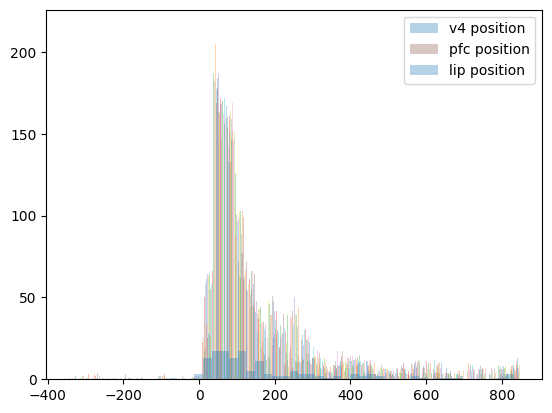

In [10]:
plt.hist(lat_rand_v4_position-350, bins=40,label="v4 position", alpha=0.33)
plt.hist(lat_rand_pfc_position-350, bins=40,label="pfc position", alpha=0.33)
plt.hist(lat_lip_position-350, bins=40,label="lip position", alpha=0.33)
plt.legend()

In [10]:

count_lip_position, bins_count = np.histogram(lat_lip_position[np.logical_and(lat_lip_position>0)], bins=10) 
pdf_lip_position    =   count_lip_position #/ sum(count_lip_position) 
cdf_lip_position    =   np.cumsum(pdf_lip_position) 
pdfn_lip_position   =   count_lip_position / sum(count_lip_position) 
cdfn_lip_position   =   np.cumsum(pdfn_lip_position) 


count_lip_neutral, bins_count = np.histogram(lat_lip_neutral[np.logical_and(lat_lip_neutral>0)], bins=10) 
pdf_lip_neutral = count_lip_neutral #/ sum(count_lip_neutral) 
cdf_lip_neutral = np.cumsum(pdf_lip_neutral) 
pdfn_lip_neutral = count_lip_neutral / sum(count_lip_neutral) 
cdfn_lip_neutral = np.cumsum(pdfn_lip_neutral) 

count_lip_orient, bins_count = np.histogram(lat_lip_orient[np.logical_and(lat_lip_orient>0)], bins=10) 
pdf_lip_orient = count_lip_orient #/ sum(count_lip_orient) 
cdf_lip_orient = np.cumsum(pdf_lip_orient) 
pdfn_lip_orient = count_lip_orient / sum(count_lip_orient) 
cdfn_lip_orient = np.cumsum(pdfn_lip_orient) 

count_lip_color, bins_count = np.histogram(lat_lip_color[np.logical_and(lat_lip_color>0)], bins=10) 
pdf_lip_color = count_lip_color #/ sum(count_lip_color) 
cdf_lip_color = np.cumsum(pdf_lip_color) 
pdfn_lip_color = count_lip_color / sum(count_lip_color) 
cdfn_lip_color = np.cumsum(pdfn_lip_color) 



count_pfc_position, bins_count = np.histogram(lat_pfc_position[np.logical_and(lat_pfc_position>0)], bins=10) 
pdf_pfc_position    =   count_pfc_position #/ sum(count_pfc_position) 
cdf_pfc_position    =   np.cumsum(pdf_pfc_position) 
pdfn_pfc_position   =   count_pfc_position / sum(count_pfc_position) 
cdfn_pfc_position   =   np.cumsum(pdfn_pfc_position) 

count_pfc_neutral, bins_count = np.histogram(lat_pfc_neutral[np.logical_and(lat_pfc_neutral>0)], bins=10) 
pdf_pfc_neutral = count_pfc_neutral #/ sum(count_pfc_neutral) 
cdf_pfc_neutral = np.cumsum(pdf_pfc_neutral) 
pdfn_pfc_neutral= count_pfc_neutral / sum(count_pfc_neutral) 
cdfn_pfc_neutral= np.cumsum(pdfn_pfc_neutral) 

count_pfc_orient, bins_count = np.histogram(lat_pfc_orient[np.logical_and(lat_pfc_orient>0)], bins=10) 
pdf_pfc_orient = count_pfc_orient #/ sum(count_pfc_orient) 
cdf_pfc_orient = np.cumsum(pdf_pfc_orient) 
pdfn_pfc_orient= count_pfc_orient / sum(count_pfc_orient) 
cdfn_pfc_orient= np.cumsum(pdfn_pfc_orient) 

count_pfc_color, bins_count = np.histogram(lat_pfc_color[np.logical_and(lat_pfc_color>0)], bins=10) 
pdf_pfc_color = count_pfc_color #/ sum(count_pfc_color) 
cdf_pfc_color = np.cumsum(pdf_pfc_color) 
pdfn_pfc_color = count_pfc_color / sum(count_pfc_color) 
cdfn_pfc_color= np.cumsum(pdfn_pfc_color) 

count_v4_position, bins_count = np.histogram(lat_v4_position[np.logical_and(lat_v4_position>0)], bins=10) 
pdf_v4_position    =   count_v4_position #/ sum(count_v4_position) 
cdf_v4_position    =   np.cumsum(pdf_v4_position) 
pdfn_v4_position   =   count_v4_position / sum(count_v4_position) 
cdfn_v4_position   =   np.cumsum(pdfn_v4_position) 

count_v4_neutral, bins_count = np.histogram(lat_v4_neutral[np.logical_and(lat_v4_neutral>0)], bins=10) 
pdf_v4_neutral = count_v4_neutral #/ sum(count_v4_neutral) 
cdf_v4_neutral = np.cumsum(pdf_v4_neutral) 
pdfn_v4_neutral = count_v4_neutral / sum(count_v4_neutral) 
cdfn_v4_neutral = np.cumsum(pdfn_v4_neutral) 

count_v4_orient, bins_count = np.histogram(lat_v4_orient[np.logical_and(lat_v4_orient>0)], bins=10) 
pdf_v4_orient = count_v4_orient #/ sum(count_v4_orient) 
cdf_v4_orient = np.cumsum(pdf_v4_orient) 
pdfn_v4_orient = count_v4_orient / sum(count_v4_orient) 
cdfn_v4_orient = np.cumsum(pdfn_v4_orient) 

count_v4_color, bins_count = np.histogram(lat_v4_color[np.logical_and(lat_v4_color>0)], bins=10) 
pdf_v4_color = count_v4_color #/ sum(count_v4_color) 
cdf_v4_color = np.cumsum(pdf_v4_color) 
pdfn_v4_color = count_v4_color / sum(count_v4_color) 
cdfn_v4_color = np.cumsum(pdfn_v4_color) 

fig, ax      =   plt.subplots(3,4,figsize=(10,5))

ax[0,0].plot(bins_count[1:]-400, cdf_lip_position, label="LIP position") 
ax[0,0].plot(bins_count[1:]-400, cdf_pfc_position, label="PFC position") 
ax[0,0].plot(bins_count[1:]-400, cdf_v4_position, label="V4 position") 
ax[0,0].legend()  

ax[1,0].plot(bins_count[1:]-400, cdfn_lip_position, label="LIP position") 
ax[1,0].plot(bins_count[1:]-400, cdfn_pfc_position, label="PFC position") 
ax[1,0].plot(bins_count[1:]-400, cdfn_v4_position, label="V4 position") 
ax[1,0].legend()    

ax[2,0].hist()

ax[0,1].plot(bins_count[1:]-400, cdf_lip_neutral, label="LIP neutral") 
ax[0,1].plot(bins_count[1:]-400, cdf_pfc_neutral, label="PFC neutral") 
ax[0,1].plot(bins_count[1:]-400, cdf_v4_neutral, label="V4 neutral") 
ax[0,1].legend()    


ax[1,1].plot(bins_count[1:]-400, cdfn_lip_neutral, label="LIP neutral") 
ax[1,1].plot(bins_count[1:]-400, cdfn_pfc_neutral, label="PFC neutral") 
ax[1,1].plot(bins_count[1:]-400, cdfn_v4_neutral, label="V4 neutral") 
ax[1,1].legend()    

# ax[1,0].boxplot([lat_lip_neutral[np.logical_and(lat_lip_neutral>0, lat_lip_neutral< 1200)]-400, 
#                 lat_pfc_neutral[np.logical_and(lat_pfc_neutral>0, lat_pfc_neutral< 1200)]-400,
#                 lat_v4_neutral[np.logical_and(lat_v4_neutral>0, lat_v4_neutral< 1200)]-400])



ax[0,2].plot(bins_count[1:]-400, cdf_lip_orient, label="lip orient") 
ax[0,2].plot(bins_count[1:]-400, cdf_pfc_orient, label="pfc orient") 
ax[0,2].plot(bins_count[1:]-400, cdf_v4_orient, label="V4 orient") 
ax[0,2].legend()    

ax[1,2].plot(bins_count[1:]-400, cdfn_lip_orient, label="lip orient") 
ax[1,2].plot(bins_count[1:]-400, cdfn_pfc_orient, label="pfc orient") 
ax[1,2].plot(bins_count[1:]-400, cdfn_v4_orient, label="V4 orient") 
ax[1,2].legend()    


# ax[1,1].boxplot([lat_lip_orient[np.logical_and(lat_lip_orient>0, lat_lip_orient< 1200)]-400,
#                 lat_pfc_orient[np.logical_and(lat_pfc_orient>0, lat_pfc_orient< 1200)]-400,
#                 lat_v4_orient[np.logical_and(lat_v4_orient>0, lat_v4_orient< 1200)]-400])


ax[0,3].plot(bins_count[1:]-400, cdf_lip_color, label="lip color") 
ax[0,3].plot(bins_count[1:]-400, cdf_pfc_color, label="pfc color") 
ax[0,3].plot(bins_count[1:]-400, cdf_v4_color, label="v4 color") 
ax[0,3].legend() 


ax[1,3].plot(bins_count[1:]-400, cdfn_lip_color, label="lip color") 
ax[1,3].plot(bins_count[1:]-400, cdfn_pfc_color, label="pfc color") 
ax[1,3].plot(bins_count[1:]-400, cdfn_v4_color, label="v4 color") 
ax[1,3].legend() 

# ax[1,2].boxplot([lat_lip_color[np.logical_and(lat_lip_color>0, lat_lip_color< 1200)]-400,
#                 lat_pfc_color[np.logical_and(lat_pfc_color>0, lat_pfc_color< 1200)]-400,
#                 lat_v4_color[np.logical_and(lat_v4_color>0, lat_v4_color< 1200)]-400])

TypeError: logical_and() takes from 2 to 3 positional arguments but 1 were given

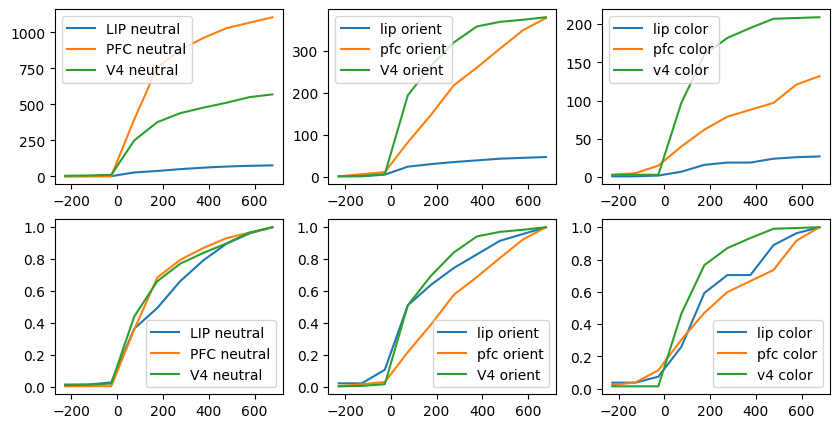

In [11]:
fig, ax      =   plt.subplots(2,3,figsize=(10,5))
count_lip_neutral, bins_count = np.histogram(lat_lip_neutral[np.logical_and(lat_lip_neutral>0, lat_lip_neutral< 1200)], bins=10) 
pdf_lip_neutral = count_lip_neutral #/ sum(count_lip_neutral) 
cdf_lip_neutral = np.cumsum(pdf_lip_neutral) 
pdfn_lip_neutral = count_lip_neutral / sum(count_lip_neutral) 
cdfn_lip_neutral = np.cumsum(pdfn_lip_neutral) 

count_lip_orient, bins_count = np.histogram(lat_lip_orient[np.logical_and(lat_lip_orient>0, lat_lip_orient< 1200)], bins=10) 
pdf_lip_orient = count_lip_orient #/ sum(count_lip_orient) 
cdf_lip_orient = np.cumsum(pdf_lip_orient) 
pdfn_lip_orient = count_lip_orient / sum(count_lip_orient) 
cdfn_lip_orient = np.cumsum(pdfn_lip_orient) 

count_lip_color, bins_count = np.histogram(lat_lip_color[np.logical_and(lat_lip_color>0, lat_lip_color< 1200)], bins=10) 
pdf_lip_color = count_lip_color #/ sum(count_lip_color) 
cdf_lip_color = np.cumsum(pdf_lip_color) 
pdfn_lip_color = count_lip_color / sum(count_lip_color) 
cdfn_lip_color = np.cumsum(pdfn_lip_color) 


count_pfc_neutral, bins_count = np.histogram(lat_pfc_neutral[np.logical_and(lat_pfc_neutral>0, lat_pfc_neutral< 1200)], bins=10) 
pdf_pfc_neutral = count_pfc_neutral #/ sum(count_pfc_neutral) 
cdf_pfc_neutral = np.cumsum(pdf_pfc_neutral) 
pdfn_pfc_neutral= count_pfc_neutral / sum(count_pfc_neutral) 
cdfn_pfc_neutral= np.cumsum(pdfn_pfc_neutral) 

count_pfc_orient, bins_count = np.histogram(lat_pfc_orient[np.logical_and(lat_pfc_orient>0, lat_pfc_orient< 1200)], bins=10) 
pdf_pfc_orient = count_pfc_orient #/ sum(count_pfc_orient) 
cdf_pfc_orient = np.cumsum(pdf_pfc_orient) 
pdfn_pfc_orient= count_pfc_orient / sum(count_pfc_orient) 
cdfn_pfc_orient= np.cumsum(pdfn_pfc_orient) 

count_pfc_color, bins_count = np.histogram(lat_pfc_color[np.logical_and(lat_pfc_color>0, lat_pfc_color< 1200)], bins=10) 
pdf_pfc_color = count_pfc_color #/ sum(count_pfc_color) 
cdf_pfc_color = np.cumsum(pdf_pfc_color) 
pdfn_pfc_color = count_pfc_color / sum(count_pfc_color) 
cdfn_pfc_color= np.cumsum(pdfn_pfc_color) 

count_v4_neutral, bins_count = np.histogram(lat_v4_neutral[np.logical_and(lat_v4_neutral>0, lat_v4_neutral< 1200)], bins=10) 
pdf_v4_neutral = count_v4_neutral #/ sum(count_v4_neutral) 
cdf_v4_neutral = np.cumsum(pdf_v4_neutral) 
pdfn_v4_neutral = count_v4_neutral / sum(count_v4_neutral) 
cdfn_v4_neutral = np.cumsum(pdfn_v4_neutral) 

count_v4_orient, bins_count = np.histogram(lat_v4_orient[np.logical_and(lat_v4_orient>0, lat_v4_orient< 1200)], bins=10) 
pdf_v4_orient = count_v4_orient #/ sum(count_v4_orient) 
cdf_v4_orient = np.cumsum(pdf_v4_orient) 
pdfn_v4_orient = count_v4_orient / sum(count_v4_orient) 
cdfn_v4_orient = np.cumsum(pdfn_v4_orient) 

count_v4_color, bins_count = np.histogram(lat_v4_color[np.logical_and(lat_v4_color>0, lat_v4_color< 1200)], bins=10) 
pdf_v4_color = count_v4_color #/ sum(count_v4_color) 
cdf_v4_color = np.cumsum(pdf_v4_color) 
pdfn_v4_color = count_v4_color / sum(count_v4_color) 
cdfn_v4_color = np.cumsum(pdfn_v4_color) 

ax[0,0].plot(bins_count[1:]-400, cdf_lip_neutral, label="LIP neutral") 
ax[0,0].plot(bins_count[1:]-400, cdf_pfc_neutral, label="PFC neutral") 
ax[0,0].plot(bins_count[1:]-400, cdf_v4_neutral, label="V4 neutral") 
ax[0,0].legend()    


ax[1,0].plot(bins_count[1:]-400, cdfn_lip_neutral, label="LIP neutral") 
ax[1,0].plot(bins_count[1:]-400, cdfn_pfc_neutral, label="PFC neutral") 
ax[1,0].plot(bins_count[1:]-400, cdfn_v4_neutral, label="V4 neutral") 
ax[1,0].legend()    

# ax[1,0].boxplot([lat_lip_neutral[np.logical_and(lat_lip_neutral>0, lat_lip_neutral< 1200)]-400, 
#                 lat_pfc_neutral[np.logical_and(lat_pfc_neutral>0, lat_pfc_neutral< 1200)]-400,
#                 lat_v4_neutral[np.logical_and(lat_v4_neutral>0, lat_v4_neutral< 1200)]-400])



ax[0,1].plot(bins_count[1:]-400, cdf_lip_orient, label="lip orient") 
ax[0,1].plot(bins_count[1:]-400, cdf_pfc_orient, label="pfc orient") 
ax[0,1].plot(bins_count[1:]-400, cdf_v4_orient, label="V4 orient") 
ax[0,1].legend()    

ax[1,1].plot(bins_count[1:]-400, cdfn_lip_orient, label="lip orient") 
ax[1,1].plot(bins_count[1:]-400, cdfn_pfc_orient, label="pfc orient") 
ax[1,1].plot(bins_count[1:]-400, cdfn_v4_orient, label="V4 orient") 
ax[1,1].legend()    


# ax[1,1].boxplot([lat_lip_orient[np.logical_and(lat_lip_orient>0, lat_lip_orient< 1200)]-400,
#                 lat_pfc_orient[np.logical_and(lat_pfc_orient>0, lat_pfc_orient< 1200)]-400,
#                 lat_v4_orient[np.logical_and(lat_v4_orient>0, lat_v4_orient< 1200)]-400])


ax[0,2].plot(bins_count[1:]-400, cdf_lip_color, label="lip color") 
ax[0,2].plot(bins_count[1:]-400, cdf_pfc_color, label="pfc color") 
ax[0,2].plot(bins_count[1:]-400, cdf_v4_color, label="v4 color") 
ax[0,2].legend() 


ax[1,2].plot(bins_count[1:]-400, cdfn_lip_color, label="lip color") 
ax[1,2].plot(bins_count[1:]-400, cdfn_pfc_color, label="pfc color") 
ax[1,2].plot(bins_count[1:]-400, cdfn_v4_color, label="v4 color") 
ax[1,2].legend() 

# ax[1,2].boxplot([lat_lip_color[np.logical_and(lat_lip_color>0, lat_lip_color< 1200)]-400,
#                 lat_pfc_color[np.logical_and(lat_pfc_color>0, lat_pfc_color< 1200)]-400,
#                 lat_v4_color[np.logical_and(lat_v4_color>0, lat_v4_color< 1200)]-400])

In [20]:
lnv4=lat_v4_neutral[np.logical_and(lat_v4_neutral>0, lat_v4_neutral< 1200)]-400
lnpfc=lat_pfc_neutral[np.logical_and(lat_pfc_neutral>0, lat_pfc_neutral< 1200)]-400
lnlip=lat_lip_neutral[np.logical_and(lat_lip_neutral>0, lat_lip_neutral< 1200)]-400


lcv4=lat_v4_color[np.logical_and(lat_v4_color>0, lat_v4_color< 1200)]-400
lcpfc=lat_pfc_color[np.logical_and(lat_pfc_color>0, lat_pfc_color< 1200)]-400
lclip=lat_lip_color[np.logical_and(lat_lip_color>0, lat_lip_color< 1200)]-400


lov4=lat_v4_orient[np.logical_and(lat_v4_orient>0, lat_v4_orient< 1200)]-400
lopfc=lat_pfc_orient[np.logical_and(lat_pfc_orient>0, lat_pfc_orient< 1200)]-400
lolip=lat_lip_orient[np.logical_and(lat_lip_orient>0, lat_lip_orient< 1200)]-400
stats.ttest_ind(lolip, lopfc)

Ttest_indResult(statistic=-4.821574108386265, pvalue=1.99006155526051e-06)

In [21]:
print(['lip neutral=', np.mean(lnlip)])
print(['pfc neutral=', np.mean(lnpfc)])
print(['v4 neutral=', np.mean(lnv4)])

['lip neutral=', 236.45454545454547]
['pfc neutral=', 198.7631103074141]
['v4 neutral=', 209.05087719298245]


In [22]:
print(['lip orient=', np.mean(lolip)])
print(['pfc orient=', np.mean(lopfc)])
print(['v4 orient=', np.mean(lov4)])

['lip orient=', 169.19148936170214]
['pfc orient=', 334.7857142857143]
['v4 orient=', 147.5842105263158]


In [23]:
print(['lip color=', np.mean(lclip)])
print(['pfc color=', np.mean(lcpfc)])
print(['v4 color=', np.mean(lcv4)])

['lip color=', 203.07407407407408]
['pfc color=', 330.1287878787879]
['v4 color=', 116.04306220095694]


Ttest_indResult(statistic=-4.821574108386265, pvalue=1.99006155526051e-06)

In [ ]:
# DECODING